In [1]:
import os
from os.path import join
import numpy as np
import json
import pickle
from transformers import BertTokenizer
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import scipy.io
#import cv2
from sklearn.model_selection import train_test_split

In [2]:
amt_data_dir = "/home/zdai/repos/EgoTransformer/Data/amt_data/"
ana_file = join('Data', 'deepdiary_data', 'lifelog', 'dataset.json')
vocab_file = join('Data', 'data', 'vocabulary.p')

## Deepdiary Image-Caption pairs

In [99]:
with open(ana_file, "r") as file:
    ana = json.load(file)

In [100]:
ana['images'][0]

{'split': 'train',
 'filename': 'NC_k5UwYTT6mI_1439181800_c6bdf6025b6c47f792d5a89092a3fc33.jpg',
 'sentences': [{'tokens': ['i', 'am', 'standing', 'behind', 'a', 'tree'],
   'raw': 'i am standing behind a tree .',
   'imgid': 0,
   'sentid': 0},
  {'tokens': ['a', 'tree', 'is', 'planted', 'into', 'the', 'sidewalk'],
   'raw': 'a tree is planted into the sidewalk .',
   'imgid': 0,
   'sentid': 1},
  {'tokens': ['a', 'two-lane', 'street', 'is', 'in', 'the', 'photograph'],
   'raw': 'a two-lane street is in the photograph .',
   'imgid': 0,
   'sentid': 2},
  {'tokens': ['a',
    'car',
    'is',
    'preparing',
    'to',
    'turn',
    'onto',
    'the',
    'street'],
   'raw': 'a car is preparing to turn onto the street .',
   'imgid': 0,
   'sentid': 3},
  {'tokens': ['i',
    'am',
    'in',
    'front',
    'of',
    'a',
    'tree',
    'and',
    'can',
    'see',
    'a',
    'grass',
    'field',
    'surrounded',
    'by',
    'a',
    'small',
    'stone',
    'wall',
    '

In [101]:
img_305 = []
imgids = []

for img_name in os.listdir(amt_data_dir):
    for img_dict in ana['images']:
        if img_name == img_dict['filename']:
            img_305.append(img_dict)
            imgids.append(img_dict['imgid'])
            
print(len(imgids), len(img_305))

140 140


### Use 'amt_list.txt' directly

In [102]:
with open(join(amt_data_dir, 'amt_list.txt'), "r") as file:
    pairs_str = file.read()
    pairs = pairs_str.split('\n')[1:]
len(pairs)

1828

In [103]:
img_names = {}

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair.split('.jpg ')[-1]
    
    if img_name not in img_names:
        img_names[img_name] = [sent_ana]
    else:
        img_names[img_name].append(sent_ana)
        
len(img_names.items())

287

PIL Image width: 640, height: 480


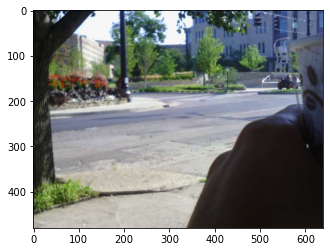

['Several trees are located across the street.', 'Flowers and trees grow in landscaping near a street.', 'I am relaxing with a beverage in the center of a town, near some plantings and a town square.', 'A person in the foreground is holding a disposable drink cup.', 'One can see a nearby intersection of two streets with flower plantings and trees and shrubs nearby.']


In [110]:
my_idx = 50
for idx, (key, val) in enumerate(img_names.items()):
    if idx == my_idx:
        img_name0, cap_lst0 = key, val

image0 = Image.open(join(amt_data_dir, img_name0))
# Transpose with respect to EXIF data
image0 = ImageOps.exif_transpose(image0)
w, h = image0.size
print("PIL Image width: {}, height: {}".format(w, h))

plt.imshow(image0)
plt.show()
print(cap_lst0)

In [116]:
img_names

{'1d3594f4d9364832bd8ef73cc11ff6e1.jpg': ['I am walking by the sign showing the schedule for yoga, Pilates and other classes at my gym.',
  'I am walking by the sign showing the schedule for yoga, Pilates and other classes at my gym.',
  'Two people are walking toward the glass doors in the lobby of a health club, about to exit onto the sidewalk.',
  'A man is standing behind a large floor sign showing the schedule for yoga, Pilates, CycleFit and circuit-strength classes.',
  'I am near a doorway leading outside the building through which I am walking.',
  'Several people are coming into the building through a revolving door.',
  'A sign is advertising physical activity classes in the hallway of a building.'],
 '60c914e4734e4070b18489d322d283ba.jpg': ['I am on a hiking trip with several other people.',
  'There are three hikers, two of which are taking photos with their phones of something in the distance.'],
 '500f6097e5604fc59e549d7c79fa795a.jpg': ['I am sitting in front of a laptop.

## Deepdiary VGG16 features & caption pairs

In [3]:
diary_data_dir = "/home/zdai/repos/EgoTransformer/Data/deepdiary_data/lifelog"
diary_ann = join(diary_data_dir, 'dataset.json')
diary_data = join(diary_data_dir, 'vgg_feats.mat')

In [18]:
diary_mat = scipy.io.loadmat(diary_data)
diary_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'feats'])

In [26]:
diary_mat['feats'][:50, 0]

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.6734771 , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  1.3378439 , -0.        ,
       -0.        , -0.        ,  0.32950062,  0.6541002 ,  0.38546413,
        1.0866879 , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  3.0956235 , -0.        ,  1.5022836 ,
       -0.        , -0.        ,  0.55367184, -0.        , -0.        ,
       -0.        , -0.        ,  2.519397  , -0.        ,  2.1698682 ,
       -0.        , -0.        , -0.        , -0.        , -0.        ],
      dtype=float32)

In [9]:
diary_mat['feats'].shape

(4096, 7210)

In [89]:
(diary_mat['feats'][:, -7] == diary_mat['feats'][:, -9]).all()

True

In [10]:
with open(diary_ann, "r") as file:
    diary_anns = json.load(file)
len(diary_anns['images'])

In [56]:
diary_anns['images'][-1]

{'split': 'train',
 'filename': 'IU_rS0Kbdoacm_1437450623_150720_181617.jpg',
 'sentences': [{'tokens': ['i',
    'am',
    'crossing',
    'some',
    'railroad',
    'tracks'],
   'raw': 'i am crossing some railroad tracks .',
   'imgid': 7209,
   'sentid': 27126},
  {'tokens': ['some',
    'cars',
    'are',
    'parked',
    'along',
    'a',
    'street',
    'and',
    'railroad',
    'tracks',
    'underneath',
    'a',
    'blue',
    'sky'],
   'raw': 'some cars are parked along a street and railroad tracks underneath a blue sky .',
   'imgid': 7209,
   'sentid': 27127},
  {'tokens': ['cars',
    'and',
    'a',
    'white',
    'pickup',
    'truck',
    'are',
    'parked',
    'on',
    'the',
    'other',
    'side',
    'of',
    'railroad',
    'tracks'],
   'raw': 'cars and a white pickup truck are parked on the other side of railroad tracks .',
   'imgid': 7209,
   'sentid': 27128},
  {'tokens': ['a', 'car', 'is', 'about', 'to', 'cross', 'the', 'intersection'],
   'raw

In [50]:
diary_pairs = diary_anns['images'].copy()

In [63]:
index = 0
ann_pairs = []
last_sent0, last_sent_1 = '', ''

for idx, item in enumerate(diary_anns['images']):
    
    if item['sentences'][0]['raw'] == last_sent0 and item['sentences'][-1]['raw'] == last_sent_1:
        diary_pairs[idx]['segment'] = index
        
        tup[0].append(diary_mat['feats'][:, idx])
        
    else:
        last_sent0 = item['sentences'][0]['raw']
        last_sent_1 = item['sentences'][-1]['raw']
        
        if idx != 0:
            ann_pairs.append(tup)
            del tup
        
        index += 1
        diary_pairs[idx]['segment'] = index
        
        # tuple of (vgg_feature_vec, [captions])
        caps = [sent['raw'] for sent in item['sentences']]
        tup = ([diary_mat['feats'][:, idx]], caps)
    
    diary_pairs[idx]['feats'] = diary_mat['feats'][:, idx]

In [81]:
ann_pairs[-1]

([array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,
          1.3867083], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,
          1.3867083], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,
          1.3867083], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,


In [58]:
with open(join(diary_data_dir, 'diary_pairs.pkl'), 'wb') as a_file:
    pickle.dump(diary_pairs, a_file)

In [59]:
### Loading ###
with open(join(diary_data_dir, 'diary_pairs.pkl'), 'rb') as a_file:
    diary_pairs = pickle.load(a_file)

In [82]:
with open(join(diary_data_dir, 'ann_pairs.pkl'), 'wb') as a_file:
    pickle.dump(ann_pairs, a_file)

In [ ]:
### Loading ###
with open(join(diary_data_dir, 'ann_pairs.pkl'), 'rb') as a_file:
    ann_pairs = pickle.load(a_file)

In [83]:
ann_pairs[-1]

([array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.38476348, -0.        , -0.        , ..., -0.        ,
          0.47582752,  1.0185504 ], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,
          1.3867083], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,
          1.3867083], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,
          1.3867083], dtype=float32),
  array([ 0.7881323, -0.       , -0.       , ..., -0.       , -0.       ,


## MSVD

In [3]:
msvd_data_dir = "/home/zdai/repos/MSVD"
msvd_ana_file = join(msvd_data_dir, 'AllVideoDescriptions.txt')
skipped_dir = join(msvd_data_dir, 'skipped')

In [4]:
pairs = []

with open(msvd_ana_file, "r") as file:
    lines = file.readlines()
    print("Num of lines = ", len(lines))
    for line in lines:
        if line != "\n" and line[0] != "#":
            pairs.append(line)
len(pairs)

Num of lines =  80834


80827

In [5]:
vid_anns = {}
min_frame_per_clip = 5

for pair in pairs:
    img_name = pair.split(' ')[0]
    sent_ana = pair[len(img_name) + 1:-1]
    
    if img_name not in vid_anns:
        # Create a list of [path_to_image]
        img_keys = []
        # Discard clip with less than N frames
        if len(os.listdir(join(skipped_dir, img_name))) < min_frame_per_clip:
            continue
        
        for frame in sorted(os.listdir(join(skipped_dir, img_name)), key=lambda x: int(x.split('.')[0][6:])):
            #print(frame)
            img_keys.append(join(skipped_dir, img_name, frame))
        #show_img(img_keys[0])
        
        vid_anns[img_name] = (img_keys, [sent_ana])
    else:
        if sent_ana in vid_anns[img_name][1]:
            continue
        vid_anns[img_name][1].append(sent_ana)
        
len(vid_anns)

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.j

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\f

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame16.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.j

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame16.jpg
\frame17.jpg
\frame18.jpg
\frame19.jpg
\frame20.jpg
\frame21.jpg
\frame22.jpg
\frame23.jpg
\frame24.jpg
\frame25.jpg
\frame26.jpg
\frame27.jpg
\frame28.jpg
\frame29.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\fram

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jp

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame16.jpg
\frame17.jpg
\frame18.jpg
\frame19.jpg
\frame20.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jp

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame16.jpg
\frame17.jpg
\frame18.jpg
\frame19.jpg
\frame20.jpg
\frame21.jpg
\frame22.jpg
\frame23.jpg
\frame24.jpg
\frame25.jpg
\frame26.jpg
\frame27.jp

\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.jpg
\frame12.jpg
\frame13.jpg
\frame14.jpg
\frame15.jpg
\frame16.jpg
\frame17.jpg
\frame18.jpg
\frame19.jpg
\frame20.jpg
\frame21.jpg
\frame22.jpg
\frame23.jpg
\frame24.jpg
\frame25.jpg
\frame26.jpg
\frame27.jpg
\frame28.jpg
\frame29.jpg
\frame30.jpg
\frame31.jpg
\frame32.jpg
\frame33.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame0.jpg
\frame1.jpg
\frame2.jpg
\frame3.jpg
\frame4.jpg
\frame5.jpg
\frame6.jpg
\frame7.jpg
\frame8.jpg
\frame9.jpg
\frame10.jpg
\frame11.

1802

In [6]:
def show_img(path_to_img):
    image0 = Image.open(path_to_img)
    # Transpose with respect to EXIF data
    image0 = ImageOps.exif_transpose(image0)
    w, h = image0.size
    print("PIL Image width: {}, height: {}".format(w, h))

    plt.imshow(image0)
    plt.show()

In [7]:
vid_anns

{'-4wsuPCjDBc_5_15': (['/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame0.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame1.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame2.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame3.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame4.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame5.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame6.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame7.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame8.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame9.jpg',
   '/home/zdai/repos/MSVD/skipped/-4wsuPCjDBc_5_15/\\frame10.jpg'],
  ['a squirrel is eating a peanut in it s shell',
   'a chipmunk is eating',
   'a chipmunk is eating a peanut',
   'a chipmunk is eating a nut',
   'a squirrel is eating a nut',
   'a squirrel is eating a whole peanut',
   'a squirrel is eating a pean

In [26]:
Anns = []

for idx, (key, val) in enumerate(vid_anns.items()):
    for index in range(len(val[1])):
        for i in range(len(val[0]) - min_frame_per_clip + 1):
            tuple_item = (val[0][i:i + min_frame_per_clip], val[1][index])
            Anns.append(tuple_item)

len(Anns)

459382

In [30]:
# Exhaustive selection
import random
window_frame_per_clip = 5
Anns_train, Anns_test = [], []

In [31]:
X_train, X_test = train_test_split(list(vid_anns.keys()), test_size=0.3, random_state=123, shuffle=True)

for idx, (key, val) in enumerate(vid_anns.items()):
    
    for i in range(len(val[0]) - window_frame_per_clip + 1):
        
        tuple_item = (val[0][i:i + window_frame_per_clip], random.choice(val[1]))
        # Split vid_anns based on whether vid_name in X_train/X_test lists
        if key in X_train:
            Anns_train.append(tuple_item)
        elif key in X_test:
            Anns_test.append(tuple_item)
            
        # Break to avoid sample too many from long clips
        if i > 15:
            break

In [32]:
print(len(Anns_train), len(Anns_test))

7830 3362


In [27]:
len(Anns)

459382

### Load with Function

In [43]:
from sklearn.model_selection import train_test_split

def read_msvd(msvd_ana_file, skipped_dir, min_frame_per_clip=7, window_frame_per_clip=5):
    # TODO: split MSVD into train / test
    pairs, Anns_train, Anns_test = [], [], []
    vid_anns = {}
    
    assert window_frame_per_clip <= min_frame_per_clip

    with open(msvd_ana_file, "r") as file:
        lines = file.readlines()
        print("Num of lines = ", len(lines))
        for line in lines:
            if line != "\n" and line[0] != "#":
                pairs.append(line)

    for pair in pairs:
        img_name = pair.split(' ')[0]
        sent_ana = pair[len(img_name) + 1:-1]

        if img_name not in vid_anns:
            # Create a list of [path_to_image]
            img_keys = []
            # Discard clip with less than N frames
            if len(os.listdir(join(skipped_dir, img_name))) < min_frame_per_clip:
                continue

            for frame in sorted(os.listdir(join(skipped_dir, img_name)), key=lambda x: int(x.split('.')[0][6:])):
                img_keys.append(join(skipped_dir, img_name, frame))

            vid_anns[img_name] = (img_keys, [sent_ana])
        else:
            if sent_ana in vid_anns[img_name][1]:
                continue
            vid_anns[img_name][1].append(sent_ana)
    
    # vid_anns is a dict of {'vid_name': (['img1.jpg', 'img2.jpg' ...], ['cap1', 'cap2' ...]), ... ...}
    #print(next(iter(vid_anns)))
    X_train, X_test = train_test_split(list(vid_anns.keys()), test_size=0.3, random_state=42, shuffle=True)

    for idx, (key, val) in enumerate(vid_anns.items()):
        for index in range(len(val[1])):
            for i in range(len(val[0]) - window_frame_per_clip + 1):
                tuple_item = (val[0][i:i + window_frame_per_clip], val[1][index])
                # Split vid_anns based on whether vid_name in X_train/X_test lists
                if key in X_train:
                    Anns_train.append(tuple_item)
                elif key in X_test:
                    Anns_test.append(tuple_item)

    return Anns_train, Anns_test

In [6]:
msvd_data_dir = "/home/zdai/repos/MSVD"
msvd_ana_file = join(msvd_data_dir, 'AllVideoDescriptions.txt')
skipped_dir = join(msvd_data_dir, 'skipped')

In [44]:
anns_train, anns_test = read_msvd(msvd_ana_file, skipped_dir, min_frame_per_clip=7, window_frame_per_clip=5)
print(len(anns_train), len(anns_test))

Num of lines =  80834
308190 130080


In [45]:
# anns_ is a list of tuple (['path/to/img1.jpg', 'path/to/img2.jpg' ...], 'A dog is sitting')
anns_test[-1]

(['/home/zdai/repos/MSVD/skipped/za-9mBZyNfQ_330_336/\\frame2.jpg',
  '/home/zdai/repos/MSVD/skipped/za-9mBZyNfQ_330_336/\\frame3.jpg',
  '/home/zdai/repos/MSVD/skipped/za-9mBZyNfQ_330_336/\\frame4.jpg',
  '/home/zdai/repos/MSVD/skipped/za-9mBZyNfQ_330_336/\\frame5.jpg',
  '/home/zdai/repos/MSVD/skipped/za-9mBZyNfQ_330_336/\\frame6.jpg'],
 'men are dancing on the wooden floor')

# EgoCap

In [2]:
egocap_dir = '/Users/zhuangzhuangdai/repos/EgoCapSurvey/doc'
egocap_filename = 'analyzed_annatations.json'

In [3]:
with open(join(egocap_dir, egocap_filename), 'r') as f:
    ana = json.load(f)

In [32]:
len(ana)

297

In [33]:
# Reference labels
ego4d_dir = '/Users/zhuangzhuangdai/ego4d_data'
with open(join(ego4d_dir, 'ego4d.json')) as f:
    ref_ego4d = json.load(f)
    
coco_dir = '/Users/zhuangzhuangdai/repos/EgoTransformer/images/annotations'
with open(join(coco_dir, 'captions_val2017.json')) as f:
    ref_coco = json.load(f)

In [43]:
len(ref_coco['annotations'])

25014

In [40]:
### Add reference labels from original {COCO, Ego4D, MSVD, MSRVTT} datasets ###
def update_ann_reference(ann, ref, ref_co):
    for idx, (key, val) in enumerate(ann.items()):
        filename = None
        try:
            # For image name parsing
            key_lst = key.split('.')[0].split('_')
            if len(key_lst) == 1:
                # COCO
                filename = key_lst[0]
                cap_lst = []
                for video_item in ref_co['annotations']:
                    if str(video_item['image_id']).zfill(12) == filename:
                        cap_lst.append(video_item['caption'])
                        
                ann[key]['reference'] = {
                            'origin': 'coco_val2017',
                            'labels': cap_lst
                        }
                
            elif len(key_lst) == 2:
                # Ego4D
                filename = key_lst[0]
                
                for video_item in ref['videos']:
                    if video_item['video_uid'] == filename:
                        labels = video_item['scenarios']
                        ann[key]['reference'] = {
                            'origin': 'Ego4D',
                            'labels': labels
                        }
                        break
            
        except:
            raise TypeError("Not an image with reference!")
            

                
    return ann

In [41]:
new_ana = update_ann_reference(ana, ref_ego4d, ref_coco)

In [44]:
# Export "analyzed_annatations_ref"
with open(join(egocap_dir, 'analyzed_annatations_ref.json'), 'w', encoding='utf-8') as f:
    json.dump(new_ana, f, ensure_ascii=False, indent=4)